# HW5 - Q1

In [99]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
widths = [1,1,2,1,2,1,2,1,2,1,1]

P1_material_idxs = [2,1,2,1,2,1,2,1,2,1,2]
P2_material_idxs = [2,1,2,1,2,3,2,1,2,1,2]
P3_material_idxs = [2,3,2,1,2,3,2,1,2,3,2]

#shift all indexes

P1_material_idxs = [i-1 for i in P1_material_idxs]
P2_material_idxs = [i-1 for i in P2_material_idxs]
P3_material_idxs = [i-1 for i in P3_material_idxs]


material_1 = {
    "Sigma_t": [0.416, 0.821],
    "Sigma_a": [0.032, 0.421],
    "nuSigma_f": [0.028, 0.795],
    "Chi": [1.00, 0.00],
    "Sigma_s": [[0.383, 0.001], [0.000, 0.400]] # first idx is "from", second idx is "to"
}

material_2 = {
    "Sigma_t": [0.886, 2.762],
    "Sigma_a": [0.000, 0.026],
    "nuSigma_f": [0.00, 0.00],
    "Chi": [0.00, 0.00],
    "Sigma_s": [[0.844, 0.042], [0.000, 2.736]]  # first idx is "from", second idx is "to"
}

material_3 = {
    "Sigma_t": [0.432, 3.473],
    "Sigma_a": [0.041, 3.059],
    "nuSigma_f": [0.028, 0.392],
    "Chi": [1.00, 0.00],
    "Sigma_s": [[0.390, 0.001], [0.000, 0.414]] # first idx is "from", second idx is "to"
}


materials=[material_1, material_2, material_3]



In [101]:
def meshing(n_mesh_per_width, widths, P_material_indexes):
    total_lenght = np.sum(widths)
    material_mesh = np.zeros(total_lenght*n_mesh_per_width)
    pos = 0
    for i in range(len(widths)):
        for j in range(n_mesh_per_width*widths[i]):
            material_mesh[pos] = P_material_indexes[i]
            pos += 1
            
    new_width = total_lenght/len(material_mesh)
    return material_mesh.astype('int'), new_width

In [102]:
def sources(material_idxs, materials, k, phi, n_groups=2): # equation (444) of chapter 9
    Q = np.zeros((len(material_idxs), n_groups))
    for i in range(len(material_idxs)):
        idx = material_idxs[i]    
        for g in range(n_groups):
            contribution = 0
            for gp in range(n_groups):
                contribution += (materials[idx]["Sigma_s"][gp][g] + (1/k)*materials[idx]["Chi"][g]*materials[idx]["nuSigma_f"][gp])*phi[i][gp]       
            
            Q[i][g] = contribution/(4*np.pi)
            
    return Q

In [103]:
def polar_angle_sweep(material_idxs,  Q, width, initial_psi, angles=[0.57735027, -0.57735027], weights=[.5, .5], materials=materials, n_groups=2):
        phi = np.zeros((len(material_idxs), n_groups))
        for i in range(len(angles)):
            if angles[i] > 0: # if positive angle I sweep from left to right
                psi = initial_psi # angular flux at left boundary, one for each group, taken equal to the last of the last track
                for g in range(n_groups):
                    for j in range(len(material_idxs)):
                        t = np.abs(width/angles[i])
                        idx = material_idxs[j]
                        tau = materials[idx]["Sigma_t"][g]*t
                        mexp = 1-np.exp(-tau)

                        delta_psi = (psi[g] - Q[j][g]/materials[idx]["Sigma_t"][g] )*mexp
                        psi_avg = psi[g]*mexp/materials[idx]["Sigma_t"][g]/t + Q[j][g]*(1-mexp/tau)/materials[idx]["Sigma_t"][g]
                        phi[j][g] = phi[j][g] + 4*np.pi*weights[i]*psi_avg
                        psi[g] = psi[g] - delta_psi

            else: # if negative angle I sweep from right to left
                psi = psi # angular flux at right boundary, one for each group, taken equal to last of the last track
                for g in range(n_groups):
                    for j in range(len(material_idxs)-1, -1, -1):
                        t = np.abs(width/angles[i])
                        idx = material_idxs[j]
                        tau = materials[idx]["Sigma_t"][g]*t
                        mexp = 1-np.exp(-tau)

                        delta_psi = (psi[g] - Q[j][g]/materials[idx]["Sigma_t"][g])*mexp
                        psi_avg = psi[g]*mexp/materials[idx]["Sigma_t"][g]/t + Q[j][g]*(1-mexp/tau)/materials[idx]["Sigma_t"][g]
                        phi[j][g] = phi[j][g] + 4*np.pi*weights[i]*psi_avg
                        psi[g] = psi[g] - delta_psi  

        return phi, psi
                                                                                              

In [104]:
def find_k(material_idxs, materials, phi, width, n_groups=2): # eq. (445) of chapter 9
    num=0
    den=0
    for i in range(len(material_idxs)):
        idx = material_idxs[i]
        for g in range(n_groups):
            num = num+materials[idx]["nuSigma_f"][g]*phi[i][g]
            den = den+materials[idx]["Sigma_a"][g]*phi[i][g]
            
    return num/den

In [105]:
def MOC(iterations, material_idxs, materials, initial_k, initial_phi, width, angles=[0.57735027, -0.57735027], weights=[.5, .5], n_groups=2):
    k_new = initial_k
    phi_new = initial_phi/np.sum(initial_phi)
    psi_last_it = [0,0]
    
    for i in range(iterations):
        print("{} - {:.4f}".format(i,k_new))
        Q = sources(material_idxs, materials, k_new, phi_new)                            # generate new sources for the mesh (function of last k and phi)
        k_old = k_new
        phi_old = phi_new
        
        phi_new, psi_last_it = polar_angle_sweep(material_idxs,  Q, width, psi_last_it)  # generate new flux (using the new sources)
        k_new = find_k(material_idxs, materials, phi_new, width)                         # compute new k (using the new flux)
        
        phi_new = phi_new/np.sum(phi_new)
        psi_last_it = psi_last_it/np.sum(phi_new)
        
        # Check for convergence
        
        err = np.zeros(len(phi_new))
        if np.abs(k_new-k_old)/k_new < 1e-5:
            for m in range(len(phi_new)):
                err[m] = np.abs((phi_new[m][1]-phi_old[m][1])/phi_new[m][1]) #check convergence of thermal flux only
            if max(err) < 1e-5:
                print(i)
                print(k_new)
                break
        
    return phi_new, k_new

.

.

## SIMULATION

In [106]:
P1_meshed, P1_mesh_width = meshing(200, widths=widths, P_material_indexes=P1_material_idxs)
phi_P1, k_P1 = MOC(2000, P1_meshed, materials, initial_k=1.0, initial_phi = np.ones((len(P1_meshed), 2)), width=P1_mesh_width)

0 - 1.0000
1 - 1.5474
2 - 1.5127
3 - 1.4896
4 - 1.4721
5 - 1.4588
6 - 1.4482
7 - 1.4397
8 - 1.4327
9 - 1.4268
10 - 1.4217
11 - 1.4172
12 - 1.4133
13 - 1.4098
14 - 1.4067
15 - 1.4039
16 - 1.4013
17 - 1.3989
18 - 1.3968
19 - 1.3948
20 - 1.3930
21 - 1.3914
22 - 1.3899
23 - 1.3885
24 - 1.3872
25 - 1.3861
26 - 1.3850
27 - 1.3840
28 - 1.3831
29 - 1.3823
30 - 1.3816
31 - 1.3809
32 - 1.3802
33 - 1.3797
34 - 1.3791
35 - 1.3787
36 - 1.3782
37 - 1.3778
38 - 1.3775
39 - 1.3771
40 - 1.3768
41 - 1.3765
42 - 1.3763
43 - 1.3760
44 - 1.3758
45 - 1.3756
46 - 1.3755
47 - 1.3753
48 - 1.3751
49 - 1.3750
50 - 1.3749
51 - 1.3748
52 - 1.3747
53 - 1.3746
54 - 1.3745
55 - 1.3744
56 - 1.3743
57 - 1.3743
58 - 1.3742
59 - 1.3742
60 - 1.3741
61 - 1.3741
62 - 1.3740
63 - 1.3740
64 - 1.3740
65 - 1.3739
66 - 1.3739
67 - 1.3739
68 - 1.3738
69 - 1.3738
70 - 1.3738
71 - 1.3738
72 - 1.3738
73 - 1.3737
74 - 1.3737
75 - 1.3737
76 - 1.3737
77 - 1.3737
78 - 1.3737
79 - 1.3737
80 - 1.3737
81 - 1.3737
82 - 1.3737
83 - 1.3737
84

In [107]:
P2_meshed, P2_mesh_width = meshing(200, widths=widths, P_material_indexes=P2_material_idxs)
phi_P2, k_P2 = MOC(2000, P2_meshed, materials, initial_k=1.0, initial_phi = np.ones((len(P2_meshed), 2)), width=P2_mesh_width)

0 - 1.0000
1 - 1.0563
2 - 1.1401
3 - 1.1556
4 - 1.1587
5 - 1.1594
6 - 1.1595
7 - 1.1594
8 - 1.1592
9 - 1.1591
10 - 1.1590
11 - 1.1589
12 - 1.1588
13 - 1.1587
14 - 1.1586
15 - 1.1585
16 - 1.1584
17 - 1.1582
18 - 1.1581
19 - 1.1580
20 - 1.1579
21 - 1.1578
22 - 1.1577
23 - 1.1576
24 - 1.1576
25 - 1.1575
26 - 1.1574
27 - 1.1574
28 - 1.1574
29 - 1.1573
30 - 1.1573
31 - 1.1573
32 - 1.1573
33 - 1.1573
34 - 1.1573
35 - 1.1573
36 - 1.1573
37 - 1.1573
38 - 1.1574
39 - 1.1574
40 - 1.1574
41 - 1.1574
42 - 1.1575
43 - 1.1575
44 - 1.1575
45 - 1.1576
46 - 1.1576
47 - 1.1576
48 - 1.1577
49 - 1.1577
50 - 1.1577
51 - 1.1578
52 - 1.1578
53 - 1.1578
54 - 1.1579
55 - 1.1579
56 - 1.1579
57 - 1.1580
58 - 1.1580
59 - 1.1580
60 - 1.1581
61 - 1.1581
62 - 1.1581
63 - 1.1582
64 - 1.1582
65 - 1.1582
66 - 1.1582
67 - 1.1583
68 - 1.1583
69 - 1.1583
70 - 1.1583
71 - 1.1584
72 - 1.1584
73 - 1.1584
74 - 1.1584
75 - 1.1584
76 - 1.1584
77 - 1.1585
78 - 1.1585
79 - 1.1585
80 - 1.1585
81 - 1.1585
82 - 1.1585
83 - 1.1586
84

In [108]:
P3_meshed, P3_mesh_width = meshing(200, widths=widths, P_material_indexes=P3_material_idxs)
phi_P3, k_P3 = MOC(2000, P3_meshed, materials, initial_k=1.0, initial_phi = np.ones((len(P3_meshed), 2)), width=P3_mesh_width)

0 - 1.0000
1 - 0.4802
2 - 0.5843
3 - 0.6212
4 - 0.6409
5 - 0.6545
6 - 0.6646
7 - 0.6724
8 - 0.6785
9 - 0.6833
10 - 0.6872
11 - 0.6903
12 - 0.6928
13 - 0.6949
14 - 0.6966
15 - 0.6980
16 - 0.6991
17 - 0.7001
18 - 0.7009
19 - 0.7016
20 - 0.7021
21 - 0.7026
22 - 0.7030
23 - 0.7033
24 - 0.7036
25 - 0.7038
26 - 0.7040
27 - 0.7041
28 - 0.7042
29 - 0.7043
30 - 0.7044
31 - 0.7045
32 - 0.7045
33 - 0.7046
34 - 0.7046
35 - 0.7046
36 - 0.7046
37 - 0.7046
38 - 0.7046
39 - 0.7046
40 - 0.7046
41 - 0.7046
42 - 0.7046
43 - 0.7046
44 - 0.7046
45 - 0.7046
46 - 0.7045
47 - 0.7045
48 - 0.7045
49 - 0.7045
50 - 0.7045
51 - 0.7045
52 - 0.7044
53 - 0.7044
54 - 0.7044
55 - 0.7044
56 - 0.7044
57 - 0.7043
58 - 0.7043
59 - 0.7043
60 - 0.7043
61 - 0.7043
62 - 0.7043
63 - 0.7043
64 - 0.7042
65 - 0.7042
66 - 0.7042
67 - 0.7042
68 - 0.7042
69 - 0.7042
70 - 0.7042
71 - 0.7042
72 - 0.7042
73 - 0.7042
74 - 0.7041
75 - 0.7041
76 - 0.7041
77 - 0.7041
78 - 0.7041
79 - 0.7041
80 - 0.7041
81 - 0.7041
82 - 0.7041
83 - 0.7041
84

.

.

.

## RESULTS

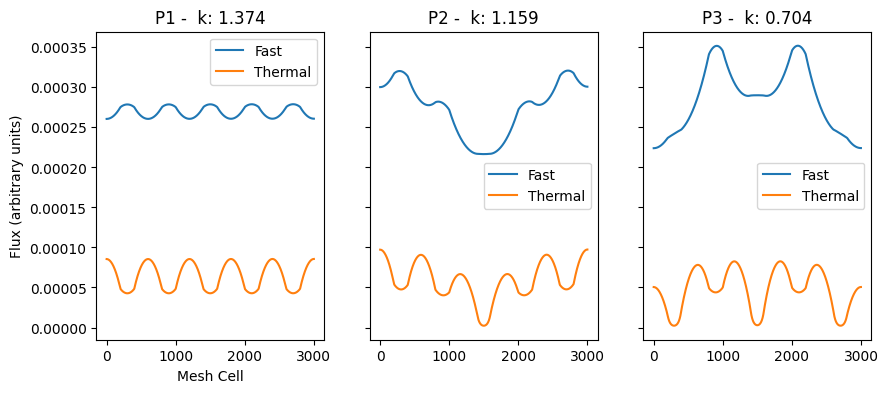

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4), sharey=True)

ax[0].plot([i[0] for i in phi_P1], label='Fast')
ax[0].plot([i[1] for i in phi_P1], label='Thermal')
ax[0].set_ylabel("Flux (arbitrary units)")
ax[0].set_xlabel("Mesh Cell")
ax[0].legend()
ax[0].set_title("P1 -  k: {:.3f}".format(k_P1))

ax[1].plot([i[0] for i in phi_P2], label='Fast')
ax[1].plot([i[1] for i in phi_P2], label='Thermal')
ax[1].legend()
ax[1].set_title("P2 -  k: {:.3f}".format(k_P2))

ax[2].plot([i[0] for i in phi_P3], label='Fast')
ax[2].plot([i[1] for i in phi_P3], label='Thermal')
ax[2].legend()
ax[2].set_title("P3 -  k: {:.3f}".format(k_P3))

plt.savefig("results_MOC.jpg", dpi=1000)